### Analysis wind information and pm10

In [1]:
# GET ALL THE JSONS INTO ONE DATAFRAME
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import json
import glob

#### Get all the pm10 files and keep columns which contain pm10

In [2]:
# Set the search path for files (assuming the directory is relative to the current script)
file_path_mc124 = os.path.join("mc124_data", "*.json")
files = glob.glob(file_path_mc124)

# Create empty list to store dataframes
li_all_files = []

# Loop through list of files and read each one into a dataframe and append to list
for f in files:
    # Read in json
    temp_df = pd.read_json(f)
    # Append df to list
    li_all_files.append(temp_df)

# Optionally concatenate all dataframes into one if needed
if li_all_files:
    combined_df = pd.concat(li_all_files)
    print(f'Combined dataframe shape: {combined_df.shape}')
else:
    print('No dataframes were created.')

Combined dataframe shape: (542555, 6)


In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542555 entries, 0 to 3654
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   542555 non-null  object 
 1   station    542555 non-null  object 
 2   core       542555 non-null  object 
 3   component  542555 non-null  object 
 4   period     542555 non-null  object 
 5   value      539422 non-null  float64
dtypes: float64(1), object(5)
memory usage: 29.0+ MB


In [4]:
# FILTER BY PARTICLE AND ONLY KEEP THE DATETIME, STATION, PERIOD AND VALUE FEATURE SINCE THE REST ARE CONSTANT INFORMATION (station, core, component, period)
df_reduced = combined_df[['datetime', 'station', 'core', 'value']]
df_reduced.sample(3)

,datetime,station,core,value
2932,2017-01-07 13:00:00+01:00,mc124,no2,50.0
2043,2023-10-14T23:00:00+02:00,mc124,no,11.0
1107,2023-03-22T17:00:00+01:00,mc124,no2,34.0


In [5]:
# CUT OFF THE TIMEZONE INFORMATION FROM THE DATETIME TO AVOID CONVERSION ISSUES DUE TO TIME CHANGE IN MARCH AND OCTOBER
df_reduced.loc[:, 'datetime'] = df_reduced['datetime'].astype(str).str.slice(0, 19)
#df_pm10_reduced.loc[:, 'datetime'] = pd.to_datetime(df_pm10_reduced['datetime'], format='mixed')
df_reduced['datetime'] = pd.to_datetime(df_reduced['datetime'], format='mixed')
df_reduced.loc[:, 'datetime'] = df_reduced['datetime'].dt.tz_localize(None)
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542555 entries, 0 to 3654
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   datetime  542555 non-null  datetime64[ns]
 1   station   542555 non-null  object        
 2   core      542555 non-null  object        
 3   value     539422 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 20.7+ MB


C:\Users\a_n_n\AppData\Local\Temp\ipykernel_10788\436813494.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['datetime'] = pd.to_datetime(df_reduced['datetime'], format='mixed')


In [6]:
df_reduced.sample(5)

,datetime,station,core,value
739,2023-12-25 20:00:00,mc124,nox,40.0
2596,2017-12-10 08:00:00,mc124,pm2,7.0
1200,2011-11-14 07:00:00,mc124,no2,55.0
796,2017-10-25 08:00:00,mc124,pm2,14.0
2979,2017-10-07 04:00:00,mc124,nox,33.0


#### Load wind data and filter for wind speed and wind direction

##### Erklärung Windrichtung  
https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv3=103182&lv2=102936  
Die Windrichtung wird bestimmt nach dem Polarwinkel (Azimut). Zur Richtungsangabe benutzt man die 360 Grad Skala des Kreises.   
Alle Richtungsangaben in Grad sind rechtweisend auf geographisch Nord bezogen, d.h.   
Ost  =  90 Grad,  
Süd  =  180 Grad,  
West =  270 Grad,   
Nord =  360 Grad.  

In [7]:
file_path_berlin = os.path.join("..", "winddaten_berlin","produkt_wind_399_akt.txt")# join because different os use either \ or / as file path seperators
weather_station = pd.read_csv(file_path_berlin, names=['stations_id','date','quality_level','structure_version', 'wind_speed', 'wind_direction', 'eor'], skiprows=1, sep=';') 
# TODO rename names
weather_station.sample(5)

,stations_id,date,quality_level,structure_version,wind_speed,wind_direction,eor
41700,399,2020120715,2,0,5.8,190,eor
38140,399,2020052200,2,0,10.1,150,eor
31042,399,2019030900,2,0,13.8,250,eor
56084,399,2022080513,2,0,3.7,280,eor
20038,399,2017120412,2,0,13.2,310,eor


In [8]:
# Convert the 'dates' column to datetime and store it in a new column 'datetime'
weather_station.loc[:,'datetime'] = pd.to_datetime(weather_station['date'], format='%Y%m%d%H')
weather_station.sample(5)

,stations_id,date,quality_level,structure_version,wind_speed,wind_direction,eor,datetime
9806,399,2016100307,2,0,1.6,130,eor,2016-10-03 07:00:00
36911,399,2020032813,2,0,7.0,340,eor,2020-03-28 13:00:00
37730,399,2020050116,2,0,6.0,220,eor,2020-05-01 16:00:00
10578,399,2016110411,2,0,9.1,230,eor,2016-11-04 11:00:00
13789,399,2017031806,2,0,15.6,220,eor,2017-03-18 06:00:00


In [9]:
# Filter neccessary rows
weather_station_reduced = weather_station[['datetime','wind_speed','wind_direction']]
weather_station_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65861 entries, 0 to 65860
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        65861 non-null  datetime64[ns]
 1   wind_speed      65861 non-null  float64       
 2   wind_direction  65861 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.5 MB


In [10]:
weather_station_reduced.sample(5)

,datetime,wind_speed,wind_direction
49249,2021-10-24 10:00:00,8.6,180
23181,2018-04-15 11:00:00,4.8,120
38635,2020-08-01 22:00:00,10.5,130
60627,2023-11-06 10:00:00,14.5,250
29253,2018-12-24 11:00:00,8.9,330


#### Merge df_reduced and weather_station_reduced based on datetime/DATETIME

In [11]:
df_merged = pd.merge(df_reduced, weather_station_reduced, on='datetime', how='outer')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542865 entries, 0 to 542864
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        542865 non-null  datetime64[ns]
 1   station         542555 non-null  object        
 2   core            542555 non-null  object        
 3   value           539422 non-null  float64       
 4   wind_speed      311477 non-null  float64       
 5   wind_direction  311477 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 24.9+ MB


In [12]:
df_merged.sample(5)

,datetime,station,core,value,wind_speed,wind_direction
358664,2020-03-12 03:00:00,mc124,nox,16.0,NaN,NaN
119567,2013-07-13 02:00:00,mc124,nox,105.0,NaN,NaN
254511,2017-11-28 04:00:00,mc124,pm2,4.0,15.6,220.0
359734,2020-03-03 05:00:00,mc124,nox,43.0,8.8,130.0
312324,2019-02-01 09:00:00,mc124,nox,70.0,16.8,140.0


In [13]:
# EXPORT AS JSON FOR LATER USE (without having to clean again)
#json_file_name = 'mc124_plus_wind_data_incl_NaN2.json'
#df_filtered.to_json(json_file_name, orient='records')

In [14]:
#Deleting all rows before March 2016 since useful pm10 data starts in March 2016
#TODO check when other particles where first measured
start_date = '2016-03-01'
start_date = pd.Timestamp(start_date)
df_filtered = df_merged[df_merged['datetime'] >= start_date]
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354537 entries, 188328 to 542864
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        354537 non-null  datetime64[ns]
 1   station         354227 non-null  object        
 2   core            354227 non-null  object        
 3   value           352295 non-null  float64       
 4   wind_speed      297587 non-null  float64       
 5   wind_direction  297587 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 18.9+ MB


In [15]:
df_filtered.head()

,datetime,station,core,value,wind_speed,wind_direction
188328,2016-03-31 23:00:00,mc124,pm10,16.0,8.3,40.0
188329,2016-03-31 23:00:00,mc124,no2,31.0,8.3,40.0
188330,2016-03-31 23:00:00,mc124,no,8.0,8.3,40.0
188331,2016-03-31 23:00:00,mc124,nox,43.0,8.3,40.0
188332,2016-03-31 22:00:00,mc124,pm10,22.0,8.4,40.0


#### Create heatmap and scatter plots to visualise relationship betwen pm10 wind_speed and wind_direction

In [16]:
df_filtered = df_filtered.drop(columns=['station'])
#df_filtered = df_filtered.drop(columns=['station', 'datetime'])
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354537 entries, 188328 to 542864
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   datetime        354537 non-null  datetime64[ns]
 1   core            354227 non-null  object        
 2   value           352295 non-null  float64       
 3   wind_speed      297587 non-null  float64       
 4   wind_direction  297587 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 16.2+ MB


In [17]:
# Pivot the DataFrame
df_pivot = df_filtered.pivot(index='datetime', columns='core', values='value')

# Include other columns by merging them back to the pivoted DataFrame
df_pivot = df_pivot.merge(df_filtered[['datetime', 'wind_speed', 'wind_direction']].drop_duplicates().dropna(), on='datetime')

# Calculate the Correlation Matrix
correlation_matrix = df_pivot.corr()

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                datetime  NaN        no       no2       nox      pm10  \
datetime        1.000000  NaN -0.242807 -0.343725 -0.283212 -0.087735   
NaN                  NaN  NaN       NaN       NaN       NaN       NaN   
no             -0.242807  NaN  1.000000  0.761484  0.980164  0.252599   
no2            -0.343725  NaN  0.761484  1.000000  0.863944  0.275885   
nox            -0.283212  NaN  0.980164  0.863944  1.000000  0.267086   
pm10           -0.087735  NaN  0.252599  0.275885  0.267086  1.000000   
pm2            -0.135405  NaN  0.204922  0.175452  0.203974  0.882997   
wind_speed      0.069484  NaN -0.216030 -0.310966 -0.253485 -0.225838   
wind_direction -0.000502  NaN  0.265513  0.234550  0.271277 -0.117976   

                     pm2  wind_speed  wind_direction  
datetime       -0.135405    0.069484       -0.000502  
NaN                  NaN         NaN             NaN  
no              0.204922   -0.216030        0.265513  
no2             0.175452   -0

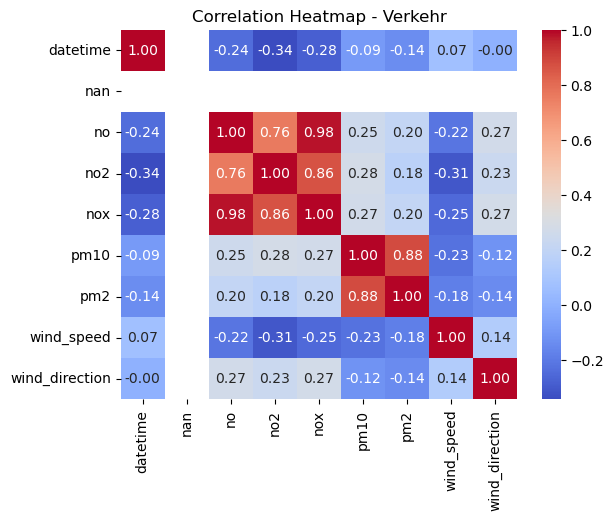

In [18]:
# show heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Verkehr")
plt.show()

Correlation Matrix:
                datetime      pm10  wind_speed  wind_direction
datetime        1.000000 -0.087735    0.073614       -0.003760
pm10           -0.087735  1.000000   -0.225838       -0.117976
wind_speed      0.073614 -0.225838    1.000000        0.137242
wind_direction -0.003760 -0.117976    0.137242        1.000000


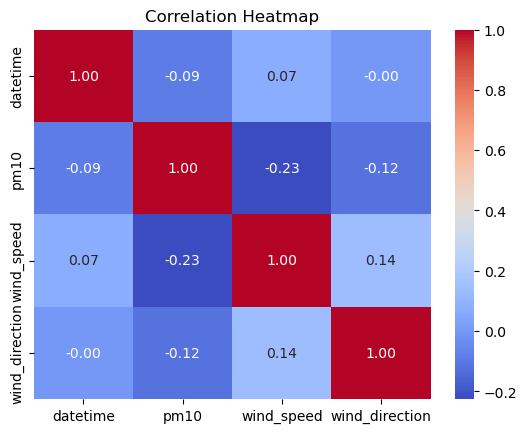

In [19]:
df_filtered = df_filtered[(df_filtered['core'] == 'pm10')]
df_reduced = df_filtered[['core', 'wind_speed', 'wind_direction']]

# Pivot the DataFrame
df_pivot = df_filtered.pivot(index='datetime', columns='core', values='value')

# Include other columns by merging them back to the pivoted DataFrame
df_pivot = df_pivot.merge(df_filtered[['datetime', 'wind_speed', 'wind_direction']].drop_duplicates().dropna(), on='datetime')

# Calculate the Correlation Matrix
correlation_matrix = df_pivot.corr()

print("Correlation Matrix:")
print(correlation_matrix)

# show heatmap with seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### KEEP IN MIND:
- when pm10 is not measured pm2 is also not measured
    - remove it from the features when training
- TODO: andere Feinstaubstationen hinzufügen (später) (durchschnitt), h-1 - h - h+1
- Datensatz mit Bike Rentals (aus den Filter)
- when adding multiple feinstaubstationen add columns with enum for Gebiet / Category it's in. f.e. "städtisches Wohngebiet"

# TODO y-data profiling
Ultrafeinstaub & Starkregen 

gleiche API: 
- Semesteraufgabe: Visualisierung aller Daten im Sommer über ein paar Wochen
- nicht alle Stationen liefern verlässlich Daten
- verschiedene Kategorien an Werten
- Kohlenmonoxidwerte in einer anderen Einheit ab und zu
- alle Daten in dictionaries -> ein Objekt mit allen Station Infos, ein Objekt mit den Werten
- Charts anzeigen lassen --> Programm starten

Uber Luftdatenapp -- Uber Luft(qualität)